In [ ]:
# 환경 변수 로드 및 auto-reload 설정
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Research Supervisor

*supervisor의 역할은 간단합니다: 연구 작업을 적절한 수의 하위 agent들에게 위임하는 것입니다.*

전체 연구 흐름은 다음과 같습니다:

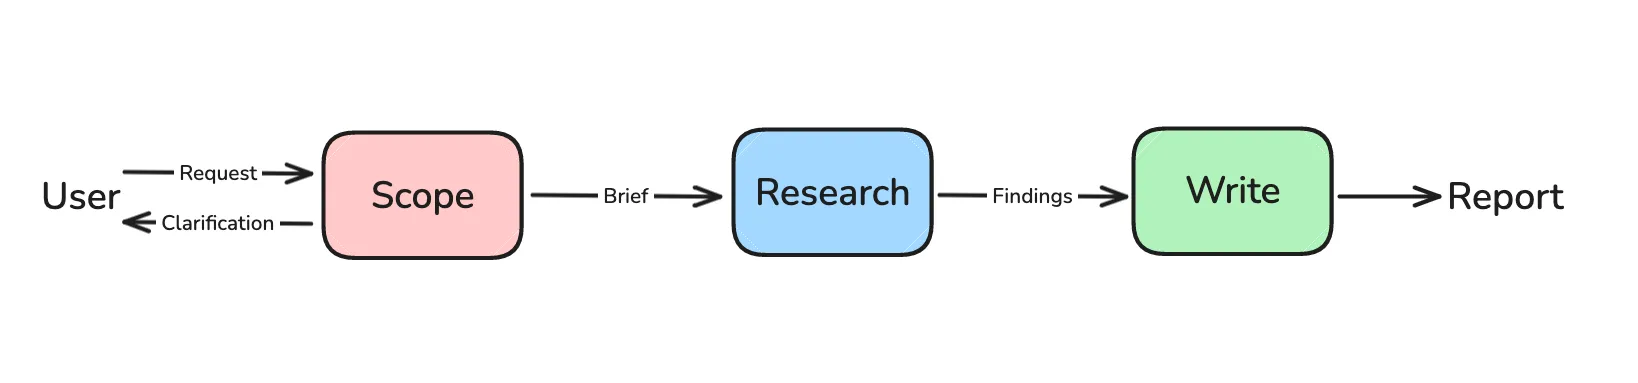

이전에 custom tool 또는 MCP server에 바인딩된 연구 agent를 구축했습니다. 그런데 요청이 복잡하고 여러 하위 주제가 있는 경우 어떻게 될까요? 단일 agent의 응답 품질은 여러 하위 주제(예: A와 B와 C를 비교)가 있을 때 *저하될 수 있습니다*. 왜냐하면 단일 컨텍스트 윈도우가 모든 하위 주제에 걸쳐 tool 피드백을 저장하고 추론해야 하기 때문입니다.

[context clash](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html)와 같은 [수많은 실패 모드](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html)는 컨텍스트 윈도우가 여러 다른 하위 주제에 걸쳐 tool 호출을 축적함에 따라 빈번하게 발생합니다. [Anthropic의 블로그 포스트](https://www.anthropic.com/engineering/built-multi-agent-research-system)에서 논의된 바와 같이, multi-agent 시스템은 하위 주제를 격리된 컨텍스트 윈도우를 가진 하위 agent들로 분할할 수 있습니다. 우리는 supervisor가 연구 브리프를 독립적인 하위 주제로 분해할 수 있는지 판단하고 격리된 컨텍스트 윈도우를 가진 하위 agent들에게 위임하는 시스템을 구축할 것입니다.

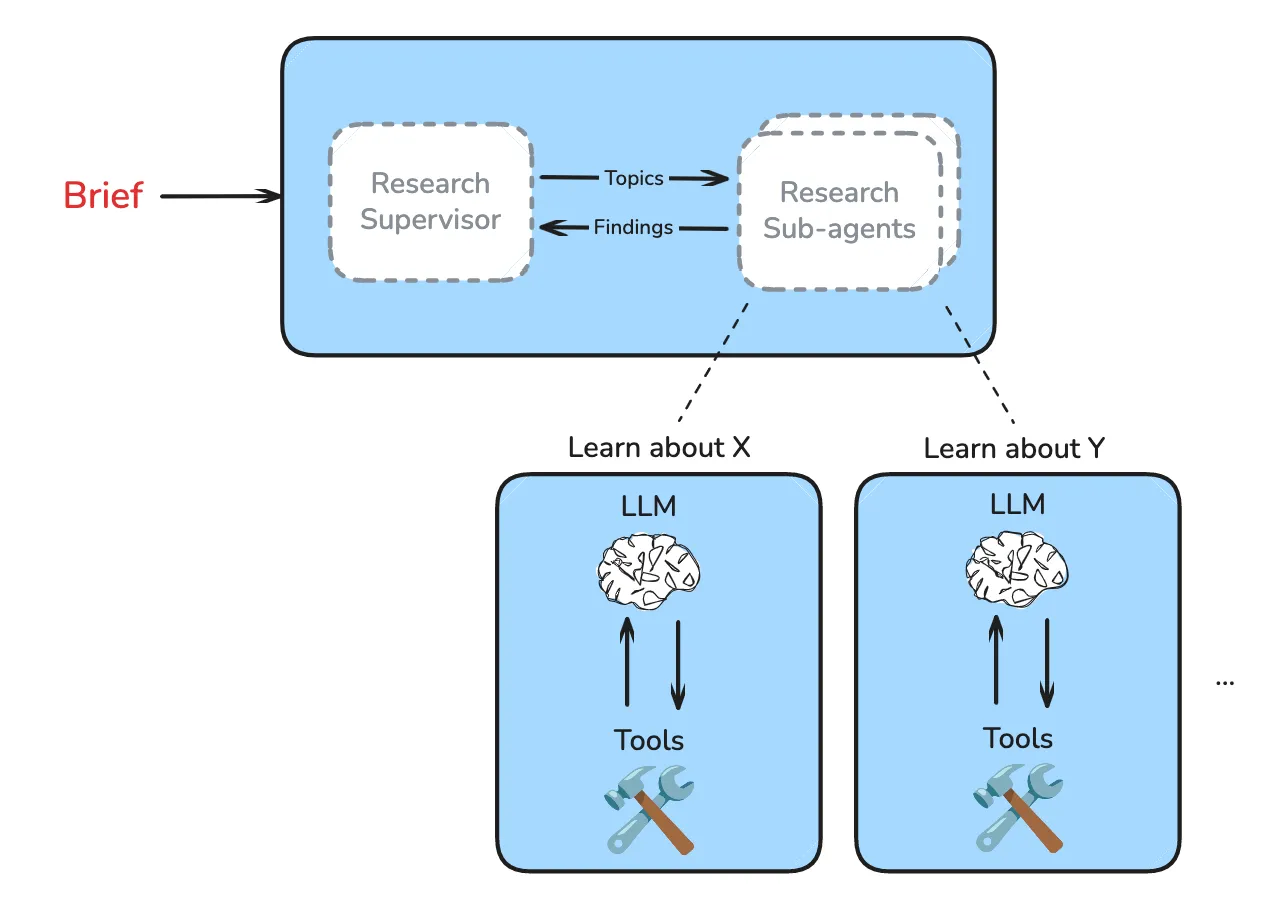

### Prompt

이제 우리가 논의한 원칙들을 따르는 supervisor를 위한 prompt를 설계하고, [연구 문헌](https://www.anthropic.com/engineering/built-multi-agent-research-system)의 통찰력을 포함하겠습니다.

#### 1. Think Like The Agent
새로운 동료에게 어떤 지시를 내릴 것인가?
- **질문을 주의 깊게 읽으세요** - 사용자가 필요로 하는 구체적인 정보는 무엇인가?
- **연구를 어떻게 위임할지 결정하세요** - 질문을 주의 깊게 고려하고 연구를 어떻게 위임할지 결정합니다. 동시에 탐색할 수 있는 여러 독립적인 방향이 있는가?
- **ConductResearch를 호출할 때마다 멈추고 평가하세요** - 답변하기에 충분한 정보가 있는가? 아직 부족한 것은 무엇인가?

#### 2. Concrete Heuristics (작업 위임을 위한)
**Hard Limits**를 사용하여 연구 agent가 도구를 과도하게 호출하는 것을 방지합니다:
- **단일 agent를 선호하세요** - 사용자 요청에 명확한 병렬화 기회가 없는 한 단순성을 위해 단일 agent를 사용합니다.
- **자신 있게 답변할 수 있을 때 중지하세요** - 완벽을 위해 연구 위임을 계속하지 마세요.
- **tool 호출 제한** - 올바른 소스를 찾을 수 없는 경우 항상 ConductResearch 3회 tool 호출 후 중지합니다.

#### 3. Show your thinking
ConductResearch tool 호출 전에 think_tool을 사용하여 접근 방식을 계획하세요:
- 작업을 더 작은 하위 작업으로 분해할 수 있는가?

각 ConductResearch tool 호출 후 think_tool을 사용하여 결과를 분석하세요:
- 어떤 핵심 정보를 찾았는가?
- 무엇이 부족한가?
- 질문에 포괄적으로 답변하기에 충분한가?
- 더 검색해야 하는가, 아니면 답변을 제공해야 하는가?

#### 4. Scaling rules
간단한 사실 찾기, 목록, 순위는 단일 하위 agent를 사용할 수 있습니다.
- *예시*: 샌프란시스코 상위 10개 커피숍 나열 -> 1개의 하위 agent 사용

사용자 요청에 제시된 비교는 비교의 각 요소마다 하위 agent를 사용할 수 있습니다.
- *예시*: OpenAI vs. Anthropic vs. DeepMind의 AI 안전성 접근 방식 비교 -> 3개의 하위 agent 사용.
- 명확하고, 구별되며, 겹치지 않는 하위 주제를 위임하세요

In [23]:
from utils import show_prompt
from deep_research_from_scratch.prompts import lead_researcher_prompt
show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

### State

supervisor state는 전체 연구 조정을 관리하고, researcher state는 개별 연구 작업을 처리합니다.

In [ ]:
%%writefile ../src/deep_research_from_scratch/state_multi_agent_supervisor.py

"""
Multi-Agent Research Supervisor를 위한 State 정의

이 모듈은 multi-agent 연구 supervisor workflow에 사용되는 state 객체와 도구를 정의합니다.
여기에는 조정 state와 연구 도구가 포함됩니다.
"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """
    Multi-agent 연구 supervisor를 위한 state.
    
    Supervisor와 연구 agent 간의 조정을 관리하고,
    연구 진행 상황을 추적하며 여러 하위 agent들로부터 발견 사항을 축적합니다.
    """
    
    # coordination과 의사결정을 위해 supervisor와 교환되는 메시지들
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # 전체 연구 방향을 안내하는 상세한 연구 브리프
    research_brief: str
    # 최종 보고서 생성을 위해 처리되고 구조화된 노트들
    notes: Annotated[list[str], operator.add] = []
    # 수행된 연구 반복 횟수를 추적하는 카운터
    research_iterations: int = 0
    # 하위 agent 연구에서 수집된 처리되지 않은 원시 연구 노트들
    raw_notes: Annotated[list[str], operator.add] = []

@tool
class ConductResearch(BaseModel):
    """연구 작업을 특화된 하위 agent에게 위임하기 위한 tool."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """연구 프로세스가 완료되었음을 나타내는 tool."""
    pass

### Multi-agent 

이제 agent를 정의하겠습니다. Multi-agent 시스템은 작업을 완료하기 위해 함께 작동하는 여러 agent로 구성된 시스템입니다. 주요 이점은 [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/)에서 논의된 바와 같이 컨텍스트 격리입니다.

In [ ]:
%%writefile ../src/deep_research_from_scratch/multi_agent_supervisor.py

"""여러 특화된 agent들 간의 연구 조정을 위한 Multi-agent supervisor.

이 모듈은 다음과 같은 supervisor 패턴을 구현합니다:
1. Supervisor agent가 연구 활동을 조정하고 작업을 위임합니다
2. 여러 researcher agent들이 특정 하위 주제에 대해 독립적으로 작업합니다
3. 결과가 최종 보고를 위해 집계되고 압축됩니다

Supervisor는 각 연구 주제에 대해 격리된 컨텍스트 윈도우를 유지하면서
효율성을 개선하기 위해 병렬 연구 실행을 사용합니다.
"""

import asyncio

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage, 
    BaseMessage, 
    SystemMessage, 
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import lead_researcher_prompt
from deep_research_from_scratch.research_agent import researcher_agent
from deep_research_from_scratch.state_multi_agent_supervisor import (
    SupervisorState, 
    ConductResearch, 
    ResearchComplete
)
from deep_research_from_scratch.utils import get_today_str, think_tool

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """Supervisor 메시지 기록에서 ToolMessage 객체로부터 연구 노트를 추출합니다.
    
    이 함수는 하위 agent들이 ToolMessage 내용으로 반환하는 압축된 연구 결과를
    검색합니다. Supervisor가 ConductResearch tool 호출을 통해 하위 agent들에게
    연구를 위임할 때, 각 하위 agent는 압축된 결과를 ToolMessage의 내용으로
    반환합니다. 이 함수는 최종 연구 노트를 컴파일하기 위해 모든 ToolMessage
    내용을 추출합니다.
    
    Args:
        messages: Supervisor의 대화 기록 메시지 목록
        
    Returns:
        ToolMessage 객체에서 추출된 연구 노트 문자열 목록
    """
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# Jupyter 환경을 위한 async 호환성 보장
try:
    import nest_asyncio
    # Jupyter/IPython 환경에서 실행 중인 경우에만 적용
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # Jupyter가 아님, nest_asyncio 불필요
except ImportError:
    pass  # nest_asyncio를 사용할 수 없음, 없이 진행


# ===== 구성 =====

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
supervisor_model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System 상수
# 개별 researcher agent들의 최대 tool 호출 반복 횟수
# 이는 무한 루프를 방지하고 주제당 연구 깊이를 제어합니다
max_researcher_iterations = 6 # think_tool + ConductResearch 호출 횟수

# supervisor가 실행할 수 있는 최대 동시 연구 agent 수
# 이는 병렬 연구 작업을 제한하기 위해 lead_researcher_prompt에 전달됩니다
max_concurrent_researchers = 3

# ===== SUPERVISOR 노드 =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """연구 활동을 조정합니다.
    
    연구 브리프와 현재 진행 상황을 분석하여 결정:
    - 어떤 연구 주제를 조사해야 하는지
    - 병렬 연구를 수행할지 여부
    - 연구가 완료되었는지 여부
    
    Args:
        state: 메시지와 연구 진행 상황이 포함된 현재 supervisor state
        
    Returns:
        업데이트된 state로 supervisor_tools 노드로 진행하는 Command
    """
    supervisor_messages = state.get("supervisor_messages", [])
    
    # 현재 날짜와 제약 조건이 포함된 system 메시지 준비
    system_message = lead_researcher_prompt.format(
        date=get_today_str(), 
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages
    
    # 다음 연구 단계에 대한 결정
    response = await supervisor_model_with_tools.ainvoke(messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """Supervisor 결정 실행 - 연구 수행 또는 프로세스 종료.
    
    처리 내용:
    - 전략적 성찰을 위한 think_tool 호출 실행
    - 다양한 주제에 대한 병렬 연구 agent 실행
    - 연구 결과 집계
    - 연구 완료 시점 결정
    
    Args:
        state: 메시지와 반복 횟수가 포함된 현재 supervisor state
        
    Returns:
        supervision을 계속하거나, 프로세스를 종료하거나, 오류를 처리하는 Command
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # 단일 반환 패턴을 위한 변수 초기화
    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"  # 기본 다음 단계
    should_end = False
    
    # 먼저 종료 조건 확인
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
    
    else:
        # 다음 단계를 결정하기 전에 모든 tool 호출 실행
        try:
            # think_tool 호출과 ConductResearch 호출 분리
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "think_tool"
            ]
            
            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls 
                if tool_call["name"] == "ConductResearch"
            ]

            # think_tool 호출 처리 (동기)
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )

            # ConductResearch 호출 처리 (비동기)
            if conduct_research_calls:
                # 병렬 연구 agent 실행
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    }) 
                    for tool_call in conduct_research_calls
                ]

                # 모든 연구가 완료될 때까지 대기
                tool_results = await asyncio.gather(*coros)

                # 연구 결과를 tool 메시지로 형식화
                # 각 하위 agent는 result["compressed_research"]에 압축된 연구 결과를 반환합니다
                # 이 압축된 연구를 ToolMessage의 내용으로 작성하면, supervisor가 나중에
                # get_notes_from_tool_calls()를 통해 이러한 결과를 검색할 수 있습니다
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]
                
                tool_messages.extend(research_tool_messages)

                # 모든 연구에서 원시 노트 집계
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", [])) 
                    for result in tool_results
                ]
                
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END
    
    # 적절한 state 업데이트로 단일 반환 지점
    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

# ===== 그래프 구성 =====

# Supervisor graph 구축
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_builder.add_edge(START, "supervisor")
supervisor_agent = supervisor_builder.compile()

In [ ]:
from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# Agent 표시
display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Multi-agent supervisor agent 실행
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = await supervisor_agent.ainvoke({"supervisor_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['supervisor_messages'])

trace를 [여기](https://smith.langchain.com/public/99eaaecd-fd9a-4ead-8eed-abdfe4ab9288/r)에서 확인할 수 있습니다.

### LangGraph Studio

이전과 마찬가지로 LangGraph Studio를 사용하여 agent를 시각화할 수 있습니다.

이 agent는 `langgraph.json` 파일에 추가되었으므로 드롭다운 메뉴에서 `research_agent_supervisor`를 선택할 수 있습니다:

```
"research_agent_supervisor": "./src/deep_research_from_scratch/multi_agent_supervisor.py:supervisor_agent",
```

studio를 시작하려면 다음 명령을 실행하세요

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval

Multi-agent의 명확한 이점은 명확하게 분리 가능한 하위 주제가 있을 때 컨텍스트 격리입니다. [블로그에서 논의한 바와 같이](https://blog.langchain.com/open-deep-research/):

> 우리의 실험은 요청에 여러 하위 주제가 있는 경우(예: A와 B와 C를 비교) 단일 agent의 응답 품질이 저하되는 것을 보여주었습니다. 여기서 직관은 간단합니다: 단일 컨텍스트 윈도우가 모든 하위 주제에 걸쳐 tool 피드백을 저장하고 추론해야 합니다. 이 tool 피드백은 종종 토큰이 많습니다. 컨텍스트 윈도우가 여러 다른 하위 주제에 걸쳐 tool 호출을 축적함에 따라 context clash와 같은 수많은 실패 모드가 빈번하게 발생합니다.

그러나 필요하지 않은 경우에는 하위 agent를 생성하지 않도록 주의해야 합니다:

> Supervisor는 요청에 필요한 연구 깊이 수준을 조정하기 위해 선택적으로 하위 agent를 생성하여 두 가지 경우를 모두 처리할 수 있습니다. Supervisor는 연구를 병렬화해야 할 때와 단일 스레드 연구로 충분할 때를 추론하기 위한 휴리스틱으로 프롬프트됩니다. 우리의 deep research agent는 연구를 병렬화할지 여부를 선택할 수 있는 유연성을 가지고 있습니다.

합리적일 때 병렬화하고 있는지 확인하기 위해 몇 가지 테스트를 설정해 보겠습니다.

In [ ]:
# 평가를 위한 think_tool 호출 및 tool 메시지가 포함된 예시 메시지들
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan).", tool_call_id="call_think_2", name="think_tool")
]

In [ ]:
import os
from langsmith import Client

# Client 초기화
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Dataset 생성
dataset_name = "deep_research_supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 2},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

이제 평가를 실행할 수 있습니다.

In [ ]:
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

첫 번째 예시에서는 agent에게 제품을 비교하고 대조하도록 요청했습니다.

이러한 종류의 문제는 parallel 연구에 적합하며, agent가 보고서를 작성할 때 결과를 종합하기 전에 각 lab에 대해 병렬로 깊이 파고들 것으로 예상합니다.

두 번째 예시는 agent에게 Chelsea, Manhattan의 상위 레스토랑을 요청합니다.

Agent는 여기서 단일 스레드의 연구를 수행해야 하며, 높은 평가를 받은 레스토랑을 나열하는 웹사이트를 반영해야 합니다.

이 순위 작업에는 명백한 병렬화 기회가 없습니다.